In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numba import jit
import time
import pandas as pd

In [108]:
dti_matrix = pd.read_csv('DTI_avg_matrix_2.csv')
#first_column = dti_matrix.iloc[:, 0]
#print(first_column)
first_column = dti_matrix['Precentral_L']
print(first_column)

0     0.000000
1     0.114779
2     0.633831
3     0.105549
4     0.001607
        ...   
87    0.000000
88    0.058762
89    0.002390
90    0.001271
91    0.000000
Name: Precentral_L, Length: 92, dtype: float64


In [109]:
n = 92
dti_c_matrix = dti_matrix.values

In [2]:
def create_nodes(n):
    values = []
    for i in range(n):
        value = random.choice([1, -1])
        values.append(value)
    return values

In [3]:
def conn_matrix(n):
    conn_matrix = np.random.uniform(0, 1, size=(n, n))
    conn_matrix = (conn_matrix + conn_matrix.T) / 2
    np.fill_diagonal(conn_matrix, 0)
    max_conn = np.max(conn_matrix)
    conn_matrix = conn_matrix / max_conn
    return conn_matrix

In [4]:
def energy_diff(list, c_matrix):
    pos = random.randint(0, n - 1)
    nodes_without_pos = [x for x in range(n) if x != pos]
    delta_E = 0
    for i in nodes_without_pos:
        add = list[pos]*list[i]*c_matrix[pos, i]
        delta_E += add
    return delta_E, pos

In [15]:
def metropolis(list, n_iterations, T, c_matrix):
    node_list = list
    magnetisation_list = []
    for i in range(n_iterations):
        diff = energy_diff(node_list, c_matrix)
        #print(diff)
        if diff[0] <= 0:
            if node_list[diff[1]] == 1: #flip at pos
                node_list[diff[1]] = -1
            else:
                node_list[diff[1]] = 1
        else:
            if random.random() < np.exp(-diff[0]/T):
                if node_list[diff[1]] == 1:
                    node_list[diff[1]] = -1
                else:
                    node_list[diff[1]] = 1

        magnetisation = np.mean(node_list)
        magnetisation_list.append(magnetisation)
    magnetisation_list = magnetisation_list[500:] #disregard first 500
    avg_magnetisation = np.mean(magnetisation_list) 
    
    mean_of_squared = np.mean([M**2 for M in magnetisation_list])
    susceptibility = (mean_of_squared - avg_magnetisation**2)/T

    return node_list, avg_magnetisation, susceptibility

In [10]:
def multi_metropolis(n_simulations, n_iterations, T):
    list_avg_magnetisation = []
    list_sus = []
    # c_matrix = dti_c_matrix # remember to change if not using connectome
    c_matrix = conn_matrix(n)
    for i in range(n_simulations):
        nodes = create_nodes(n)
        #c_matrix = conn_matrix(n)
        node_list, avg_magnetisation, susceptibility = metropolis(nodes, n_iterations, T, c_matrix) 
        list_avg_magnetisation.append(avg_magnetisation)
        list_sus.append(susceptibility)

    mean_magnet = np.mean(list_avg_magnetisation)
    std_magnet = np.std(list_avg_magnetisation)
    
    mean_sus = np.mean(list_sus)
    std_sus = np.std(list_sus)
    
    return mean_magnet, std_magnet, mean_sus, std_sus

In [13]:
temperatures = np.linspace(0.01, 10, 50)
n_simulations = 10
n_iterations = 1500
n = 5

def magnetisation_plotting(n_simulations, n_iterations):
    means_mag = []
    stds_mag = []
    means_sus = []
    stds_sus = []
    for T in temperatures:
        mean_mag, std_mag, mean_sus, std_sus = multi_metropolis(n_simulations, n_iterations, T)
        means_mag.append(mean_mag)
        stds_mag.append(std_mag)
        means_sus.append(mean_sus)
        stds_sus.append(std_sus)
    
    lower_bound = np.subtract(means_mag, stds_mag)
    upper_bound = np.add(means_mag, stds_mag)
    plt.plot(temperatures, means_mag)
    plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)
    plt.xlabel('T')
    plt.ylabel('M')
    plt.grid()
    plt.show()
    
    lower_bound = np.subtract(means_sus, stds_sus)
    upper_bound = np.add(means_sus, stds_sus)
    plt.plot(temperatures, means_sus)
    plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)
    plt.xlabel('T')
    plt.ylabel('Susceptibility')
    plt.grid()
    plt.show()

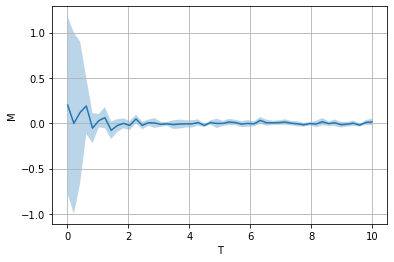

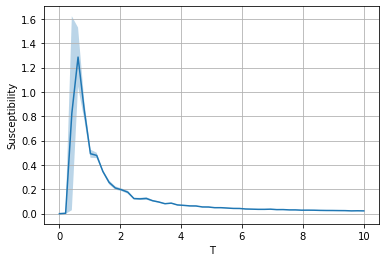

26.95000123977661


In [17]:
start_time = time.time()

magnetisation_plotting(10, 2000)

end_time = time.time()
print(end_time - start_time)